## First Simulation Study

### Load Libraries

In [1]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# split into input (X) and output (Y) variables
N = 1000 ##Sample Size
P = 1 ##Covariates
M = 100 ##replicates
X = np.array([np.ones(N)]).T ##Design matrix
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
noise_var = 0.01 ##Nugget variance
# 1000 points evenly spaced over [0,1]
s = np.linspace(0,1,N).reshape(-1,1)
mu = np.ones(N).reshape(-1,1) # vector of the means
nugget = np.eye(N) * noise_var ##Nugget matrix
cov_mat = kernel.K(s) + nugget ##Covariance matrix
# Generate M sample path with mean mu and covariance C
np.random.seed(1)
y = np.random.multivariate_normal(mu[:,0],cov_mat,M).T

In [3]:
print(y.shape) ##check the dimension of y

(1000, 100)


### Visualize the Observation

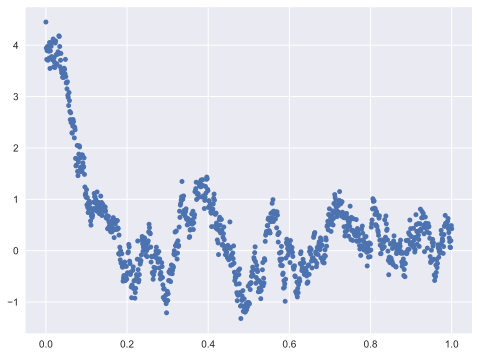

In [4]:
plt.plot(s,y[:,0],".",mew=1.5)
plt.show()
#plt.savefig("trueGP.pdf")

### Create a neural network with three hidden layers

In [5]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim = feature_dim, kernel_initializer='normal', activation='relu'))##first hidden layer
    #RBFLayer(10,initializer=InitCentersRandom(X),betas=2.0,input_shape=(num_inputs,))
    model.add(Dense(50, activation='relu'))##second hidden layer
    model.add(Dense(50, activation='relu'))##third hidden layer
    model.add(Dense(1, activation='linear'))##outpur layer
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    # Compile model
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    return model

### Generate basis functions

In [6]:
num_basis = [10,19,37,73]
knots = [np.linspace(0,1,i) for i in num_basis]
##Wendland kernel
K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/num_basis[res]*2.5
    for i in range(num_basis[res]):
        d = np.absolute(s-knots[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

Check the dimension of $s$, $X$ and $y$

In [7]:
print(s.shape)
print(X.shape)
print(y.shape)
print(phi.shape)

(1000, 1)
(1000, 1)
(1000, 100)
(1000, 139)


### Split the data

In [8]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_train, phi_test\
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, X, phi, y, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

In [10]:
print([N_train,N_test]) 

[800, 200]


** Only with X=1 **

In [11]:
model_1 = create_mlp(feature_dim = P)
 
# train the model
print("[INFO] training model 1...")
model_1.fit(X_train, y_train[:,0], validation_split = 0.2, epochs = 100, batch_size = 32, verbose = 0)

Instructions for updating:
Colocations handled automatically by placer.
[INFO] training model 1...
Instructions for updating:
Use tf.cast instead.


** With s and X **

In [12]:
model_2 = create_mlp(feature_dim = P + 1)
Xs_train = np.hstack((X_train,s_train)) 
# train the model
print("[INFO] training model 2...")
model_2.fit(Xs_train, y_train[:,0], validation_split = 0.2, epochs = 100, batch_size = 32, verbose = 0)

[INFO] training model 2...


** With RBF and X **

In [13]:
model_3 = create_mlp(feature_dim = P + K)
XRBF_train = np.hstack((X_train,phi_train)) 
# train the model
print("[INFO] training model 3...")
train_history = model_3.fit(XRBF_train, y_train[:,0], validation_split = 0.2, epochs = 500, batch_size = 32, verbose = 0)

[INFO] training model 3...


In [14]:
Xs = np.hstack((X,s))
XRBF = np.hstack((X,phi))
y0_test_1 = model_1.predict(X)
y0_test_2 = model_2.predict(Xs)
y0_test_3 = model_3.predict(XRBF)

In [15]:
print([y0_test_1.shape,y0_test_2.shape,y0_test_3.shape])

[(1000, 1), (1000, 1), (1000, 1)]


### Truth from GP

In [22]:
##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
m = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train], kernel, noise_var = noise_var)
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y0_gp = mu_GP + mu

In [23]:
m

GP_regression.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


In [31]:
print(y0_gp.shape)

(1000, 1)


In [26]:
kernel2 = GPy.kern.Matern32(1,1,1)
m2 = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train],kernel2, noise_var = noise_var)
m2.optimize()
mu_GPE,var_GPE = m2.predict(s)
lo95_GPE,up95_GPE = m2.predict_quantiles(s)
y0_gpe = mu_GPE + mu

In [27]:
m2

GP_regression.,value,constraints,priors
Mat32.variance,1.0935840049079686,+ve,
Mat32.lengthscale,0.023858801475642726,+ve,
Gaussian_noise.variance,0.02116553670527326,+ve,


In [30]:
print(y0_gpe.shape)

(1000, 1)


### Visualize results

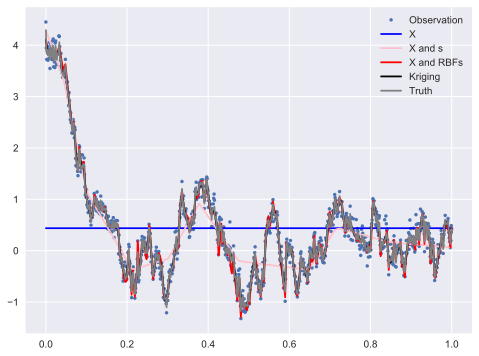

In [33]:
pylab.plot(s, y[:,0],".",label="Observation")
pylab.plot(s, y0_test_1,'blue',label="X")
pylab.plot(s, y0_test_2,'pink',label="X and s")
pylab.plot(s, y0_test_3,'red',label="X and RBFs")
pylab.plot(s, y0_gpe,'black',label="Kriging")
pylab.plot(s, y0_gp,'grey',label="Truth")
pylab.legend(loc='upper right')
pylab.show()
#plt.savefig("1D_compare.pdf")

### MSE, MAE, and Nonlinearity

In [40]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return float(rmse)
def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/y_true)
    return float(mape)

In [53]:
import time
rmse_combine = np.zeros((3,M))
mape_combine = np.zeros((3,M))
y_test0=np.zeros((2,M))
x_test0=np.zeros(M)
for i in range(M):
    print("[INFO] training %s -th replicate..." % (i+1))
    start_time1 = time.time()
    m = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)] - mu[idx_train], kernel, noise_var = noise_var)
    mu_GP_test,var_GP_test = m.predict(s_test)
    y_gp_test = mu_GP_test + mu[idx_test]
    print("--- %s seconds ---" % (time.time() - start_time1))
    start_time2 = time.time()
    kernel2 = GPy.kern.Matern32(1,1,1)
    m2 = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)] - mu[idx_train],kernel2, noise_var = noise_var)
    m2.optimize()
    mu_GPE_test,var_GPE_test = m2.predict(s_test)
    y_gpe_test = mu_GPE_test + mu[idx_test]
    print("--- %s seconds ---" % (time.time() - start_time2))
    start_time3 = time.time()
    model_3.fit(XRBF_train, y_train[:,i], validation_split = 0.2, epochs = 500, batch_size = 32, verbose = 0)
    y_dk_test = model_3.predict(XRBF[idx_test,:])
    print("--- %s seconds ---" % (time.time() - start_time2))
    rmse_combine[:,i] = np.array([rmse(y_test,y_gp_test),rmse(y_test,y_gpe_test),rmse(y_test,y_dk_test)])
    mape_combine[:,i] = np.array([mape(y_test,y_gp_test),mape(y_test,y_gpe_test),mape(y_test,y_dk_test)])
    y_test0[:,i:i+1]=np.array([y_dk_test[0],y_gp_test[0]])
    print(y_test0[:,i:i+1])
    print(rmse_combine[:,i])
    print(mape_combine[:,i])

[INFO] training1replicate...
--- 0.08342504501342773 seconds ---
--- 1.527029037475586 seconds ---
--- 12.326221227645874 seconds ---
[[0.62965751]
 [0.57072595]]
[1.49022583 1.48951934 1.50109175]
[0.94674398 0.95159347 0.99114511]
[INFO] training2replicate...
--- 0.07081103324890137 seconds ---
--- 1.4466149806976318 seconds ---
--- 12.328006029129028 seconds ---
[[1.04390407]
 [0.94078509]]
[1.58736448 1.58497007 1.58991886]
[0.30364718 0.29226112 0.23270807]
[INFO] training3replicate...
--- 0.06978583335876465 seconds ---
--- 1.638031244277954 seconds ---
--- 12.483854055404663 seconds ---
[[0.18401897]
 [0.2773045 ]]
[1.31041664 1.31022578 1.3194446 ]
[0.58695765 0.60872706 0.59468406]
[INFO] training4replicate...
--- 0.07195115089416504 seconds ---
--- 1.7825720310211182 seconds ---
--- 12.5627920627594 seconds ---
[[2.04612732]
 [2.19873838]]
[1.31053039 1.30914121 1.31231125]
[0.70406861 0.70850013 0.59361377]
[INFO] training5replicate...
--- 0.07097387313842773 seconds ---
---

--- 1.3547840118408203 seconds ---
--- 11.981819868087769 seconds ---
[[-0.96052539]
 [-1.20529558]]
[1.74655603 1.74507798 1.71743322]
[1.02663195 1.06475541 0.95274381]
[INFO] training37replicate...
--- 0.07319092750549316 seconds ---
--- 1.5209777355194092 seconds ---
--- 12.833751678466797 seconds ---
[[0.59141088]
 [0.58923824]]
[1.32229226 1.32451952 1.32834975]
[0.61799303 0.61722976 0.63362463]
[INFO] training38replicate...
--- 0.07117176055908203 seconds ---
--- 1.5865373611450195 seconds ---
--- 13.06181812286377 seconds ---
[[1.45132828]
 [1.20806954]]
[1.37825136 1.37995624 1.37623441]
[0.50935608 0.50403336 0.51987904]
[INFO] training39replicate...
--- 0.06539011001586914 seconds ---
--- 1.3852989673614502 seconds ---
--- 12.14125108718872 seconds ---
[[0.99320507]
 [1.06037139]]
[1.81101395 1.81354049 1.76483069]
[0.86632733 0.8960884  0.84275455]
[INFO] training40replicate...
--- 0.06527018547058105 seconds ---
--- 1.4637291431427002 seconds ---
--- 12.344429016113281 se

--- 1.7177300453186035 seconds ---
--- 12.450671195983887 seconds ---
[[1.58987665]
 [1.75095362]]
[1.34201636 1.34094848 1.36104421]
[0.78297299 0.74638057 0.72835011]
[INFO] training72replicate...
--- 0.07284235954284668 seconds ---
--- 1.6611230373382568 seconds ---
--- 12.388842821121216 seconds ---
[[1.44358373]
 [1.42637907]]
[1.14898443 1.14751569 1.15632196]
[0.27678897 0.28773082 0.28256221]
[INFO] training73replicate...
--- 0.06905412673950195 seconds ---
--- 1.9074702262878418 seconds ---
--- 12.68358302116394 seconds ---
[[1.34406257]
 [1.33203035]]
[1.22930125 1.22981003 1.25726633]
[0.6691108  0.68122486 0.66898363]
[INFO] training74replicate...
--- 0.07135272026062012 seconds ---
--- 1.7073240280151367 seconds ---
--- 12.41477108001709 seconds ---
[[0.36829758]
 [0.50563382]]
[1.52714466 1.53073926 1.55065158]
[0.50263679 0.49455832 0.45835875]
[INFO] training75replicate...
--- 0.07310819625854492 seconds ---
--- 1.418431043624878 seconds ---
--- 12.152977228164673 secon

In [93]:
print(np.mean(rmse_combine,axis=1))
print(np.std(rmse_combine,axis=1))
print(np.mean(mape_combine,axis=1))
print(np.std(mape_combine,axis=1))

[1.41373171 1.41339409 1.42547782]
[0.17184095 0.1716979  0.16193876]
[0.71964061 0.71921096 0.71833076]
[0.30950412 0.31114041 0.30868447]
